# Forecast the onset of diabetes mellitus


This notebook performs exploratory data analysis and trains a machine learning model to predict the onset of diabetes type I using a dataset provided by [National Institute of Diabetes and Digestive and Kidney Diseases](https://www.niddk.nih.gov/).

Diabetes mellitus type 1 (also known as type 1 diabetes) is a form of diabetes mellitus in which not enough insulin is produced. This results in high blood sugar levels in the body. The classical symptoms are frequent urination, increased thirst, increased hunger, and weight loss. Additional symptoms may include blurry vision, feeling tired, and poor healing. Symptoms typically develop over a short period of time.[1]

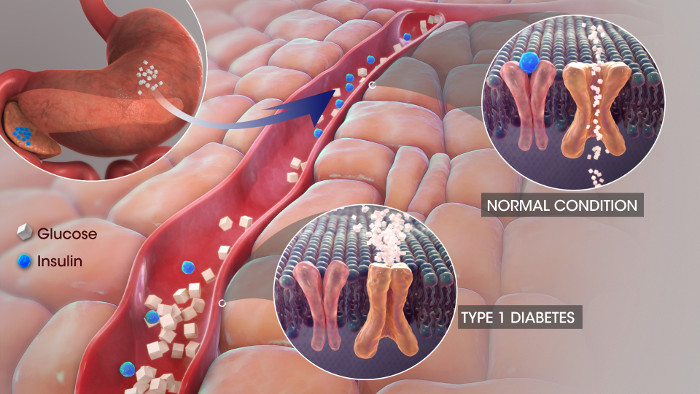

The dataset contains the following attributes:

   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

Several constraints were placed on the selection of these instances from a larger database.  In particular, all patients here are females at least 21 years old of Pima Indian heritage. 

The diagnostic, binary-valued variable investigated is whether the patient shows signs of diabetes according to World Health Organization criteria (i.e., if the 2 hour post-load plasma glucose was at least 200 mg/dl at any survey  examination or if found during routine medical care). The population lives near Phoenix, Arizona, USA.

[1] [https://en.wikipedia.org/wiki/Diabetes_mellitus_type_1](Diabetes mellitus type 1)

[2] Smith,~J.~W., Everhart,~J.~E., Dickson,~W.~C., Knowler,~W.~C., Johannes,~R.~S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus.  In *Proceedings of the Symposium        on Computer Applications and Medical Care* (pp. 261--265). IEEE Computer Society Press.


## Loading the dataset

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, accuracy_score, f1_score

import numpy as np
import pandas as pd
import seaborn as sns

import requests
import json
import math
import sklearn
import os

In [2]:
dataDF = pd.read_csv("data/pima-indians-diabetes.csv")
dataDF.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigree,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


It apperas that the csv file doesn't include any attribute names. Let's remedy this.

In [3]:
dataDF.columns = ["TimesPregnant", "Glucose", "BP", "SkinFold", "Insulin", "BMI", "Pedigree", "Age", "Diabetes"]
dataDF.head()

,TimesPregnant,Glucose,BP,SkinFold,Insulin,BMI,Pedigree,Age,Diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Explore the data

First, we check the number of samples in the set.

In [4]:
dataDF.count()

TimesPregnant    768
Glucose          768
BP               768
SkinFold         768
Insulin          768
BMI              768
Pedigree         768
Age              768
Diabetes         768
dtype: int64

Next, we define a function that we can use to plot histograms for all variables in the dataset. 

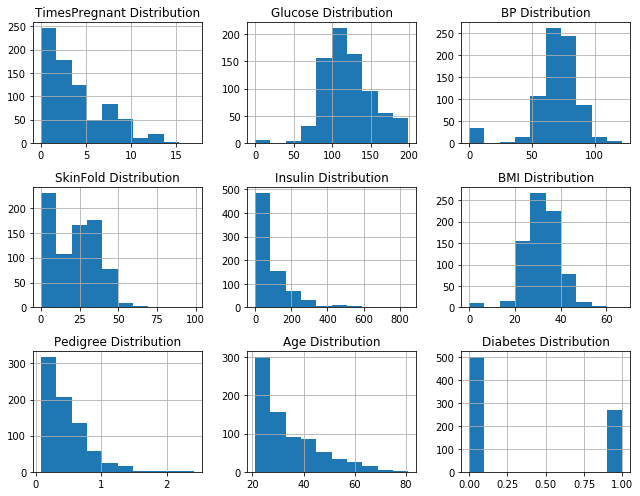

In [5]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(9, 7))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name + " Distribution")
    fig.tight_layout()
    plt.show()

draw_histograms(dataDF, dataDF.columns, 3, 3)

We can also look at a correlation matrix to see if we can establish a relationship between certain attributes.

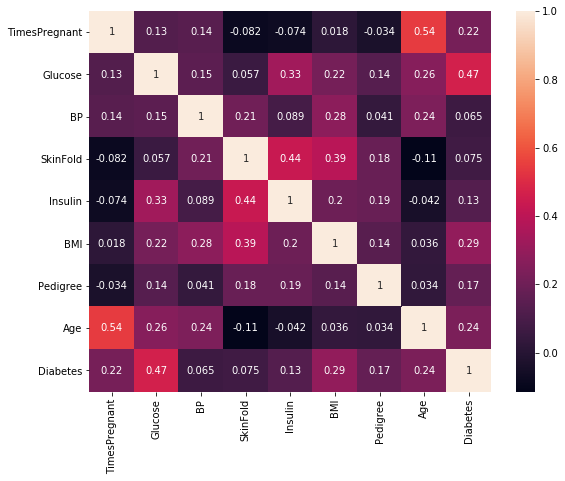

In [6]:
plt.figure(figsize=(9, 7))

sns.heatmap(dataDF.corr(), annot = True)

## Missing values imputaiton

It appears that the data doesn't suffer from missing values.

In [7]:
dataDF.isnull().values.any()

False

However, it also looks like there are some values inside that don't make sense. For example insulin and glucose levels of 0.

In [8]:
dataDF[dataDF["Glucose"]==0]

,TimesPregnant,Glucose,BP,SkinFold,Insulin,BMI,Pedigree,Age,Diabetes
75,1,0,48,20,0,24.7,0.140,22,0
182,1,0,74,20,23,27.7,0.299,21,0
342,1,0,68,35,0,32.0,0.389,22,0
349,5,0,80,32,0,41.0,0.346,37,1
502,6,0,68,41,0,39.0,0.727,41,1


Instead of dropping all rows that contain zeros, we can apply missing value imputation and replace the zeros with the attribute mean.

In [9]:
columns_of_interest = ["Glucose", "BP", "SkinFold", "BMI", "Insulin"]

for column in columns_of_interest:
    dataDF[column] = dataDF[column].replace(0, np.NaN)
    mean = int(dataDF[column].mean(skipna=True))
    dataDF[column] = dataDF[column].replace(np.NaN, mean)

In [10]:
dataDF[dataDF["Glucose"]==0]

,TimesPregnant,Glucose,BP,SkinFold,Insulin,BMI,Pedigree,Age,Diabetes


We can now look again at samples 74 and confirm that the glucose and insulin attributes have been populated.

In [11]:
dataDF.iloc[74]

TimesPregnant      1.000
Glucose           79.000
BP                75.000
SkinFold          30.000
Insulin          155.000
BMI               32.000
Pedigree           0.396
Age               22.000
Diabetes           0.000
Name: 74, dtype: float64

## Splitting the dataset

We split the data into two sets -- train (80%) and test (20%)

In [12]:
y = dataDF["Diabetes"]
X = dataDF.drop("Diabetes", 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234, test_size=0.20)

## Model 1 : Gradient Boost Clasifier

GB builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage n_classes_ regression trees are fit on the negative gradient of the binomial or multinomial deviance loss function. Binary classification is a special case where only a single regression tree is induced.

### Performing Grid Search to get the optimal model parameters

In [13]:
gradient_boost_search = GradientBoostingClassifier(random_state=0)

Exhaustive search over specified parameter values for an estimator.

Important members are fit, predict.

GridSearchCV implements a “fit” and a “score” method. It also implements “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.

The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

In [14]:
params = {
    'learning_rate': [0.05, 0.1, 0.5],
    'max_features': [0.5, 1],
    'max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(gradient_boost_search, params, cv=10, scoring='roc_auc')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'learning_rate': 0.05, 'max_depth': 4, 'max_features': 0.5}
0.8461485248815429


### Training a Gradient Boost Classifier

In [15]:
gradient_boost = GradientBoostingClassifier(learning_rate=0.05, max_depth=4, max_features=1, random_state=0)
gradient_boost.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features=1, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

In [16]:
y_pred = gradient_boost.predict(X_test)

In [17]:
print(f1_score(y_test, y_pred))

0.5434782608695652


In [18]:
print("Accuracy score: %.2f" % accuracy_score(y_test, y_pred))

Accuracy score: 0.73


In [19]:
print (confusion_matrix(y_test, y_pred))

[[87 12]
 [30 25]]


## Model 2 : Support Vector Machine

### Feature scaling

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual feature do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).

Standardize features by removing the mean and scaling to unit variance

Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Mean and standard deviation are then stored to be used on later data using the transform method.

In [20]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

### Train SVM

We use C-Support Vector Classification.

The implementation is based on libsvm. The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to dataset with more than a couple of 10000 samples.

In [21]:
classifier = SVC(random_state=0, kernel='rbf')
classifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [22]:
y_pred = classifier.predict(X_test)

### Evaluate

In [23]:
print(f1_score(y_test, y_pred))

0.5393258426966292


In [24]:
print("Accuracy score: %.2f" % accuracy_score(y_test, y_pred))

Accuracy score: 0.73


In [25]:
print (confusion_matrix(y_test, y_pred))

[[89 10]
 [31 24]]


It appears that our first model performs better in terms of accuracy.